In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler

import cmdstanpy
from cmdstanpy import CmdStanModel

In [30]:
df = pd.read_csv("df_balanced.csv")

In [33]:
stan_code = r"""
data {
  int<lower=1> N;                         // total observations
  int<lower=1> I;                         // number of donors
  int<lower=1> K;                         // number of target variables (K = 5)
  int<lower=1> P;                         // number of covariates

  array[N] int<lower=1, upper=I> id;      // donor index for each observation
  matrix[N, K] Y;                         // log target variables (meglio se centrate!)
  matrix[N, P] X;                         // covariate matrix
}

parameters {
  // fixed effects (P x K)
  matrix[P, K] beta;

  // Bayesian Ridge
  real<lower=0> sigma_beta;

  // Random effects
  matrix[I, K] z_b;
  vector<lower=0>[K] tau_b;
  cholesky_factor_corr[K] L_Omega_b;

  // Residual covariance
  vector<lower=0>[K] tau_eps;
  cholesky_factor_corr[K] L_Omega_eps;
}

transformed parameters {
  matrix[K, K] L_Sigma_b = diag_pre_multiply(tau_b, L_Omega_b);

  // random effects
  matrix[I, K] b;
  {
    matrix[K, I] z_b_t = z_b';
    matrix[K, I] b_t   = L_Sigma_b * z_b_t;
    b = b_t';
  }

  matrix[K, K] L_Sigma = diag_pre_multiply(tau_eps, L_Omega_eps);
}

model {
  // Bayesian Ridge prior on fixed effects
  sigma_beta ~ student_t(3, 0, 2.5);

  to_vector(beta) ~ normal(0, sigma_beta);

  // Prior for random effects
  tau_b ~ normal(0, 0.5) T[0, ];
  L_Omega_b ~ lkj_corr_cholesky(4);
  to_vector(z_b) ~ normal(0, 1);

  // Prior for residual covariance
  tau_eps ~ normal(0, 0.5) T[0, ];
  L_Omega_eps ~ lkj_corr_cholesky(4);

  // Likelihood
  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    Y[n] ~ multi_normal_cholesky(mu_n, L_Sigma);
  }
}
generated quantities {
  vector[N] log_lik;
  matrix[N, K] Y_rep;

  matrix[N, K] mu;

  // Full covariance matrices (K x K) from Cholesky factors
  cov_matrix[K] Sigma_b = tcrossprod(L_Sigma_b);
  cov_matrix[K] Sigma_eps = tcrossprod(L_Sigma);

  // Correlation matrices (K x K) from Cholesky factors
  corr_matrix[K] Omega_b = tcrossprod(L_Omega_b);
  corr_matrix[K] Omega_eps = tcrossprod(L_Omega_eps);

  for (n in 1:N) {
    row_vector[K] mu_n_row = X[n] * beta + b[id[n]];

    vector[K] mu_n_vec = mu_n_row';

    mu[n] = mu_n_row;

    // Pointwise Log-likelihood
    log_lik[n] = multi_normal_cholesky_lpdf(Y[n]' | mu_n_vec, L_Sigma);

    // Posterior Prediction
    Y_rep[n] = multi_normal_cholesky_rng(mu_n_vec, L_Sigma)';
  }
}
"""

stan_file = "Model_4_SESSO.stan"
with open(stan_file, "w") as f:
    f.write(stan_code)

print("Stan model written to:", stan_file)

# Compilazione
model = CmdStanModel(stan_file=stan_file)

18:20:43 - cmdstanpy - INFO - compiling stan file /var/folders/97/_n7g3p_94wb_zs30j_q45kbc0000gn/T/tmp2zvjsdpu/tmpl6hjt9mc.stan to exe file /Users/martinacaliandro/Downloads/BS Project/Model_4_SESSO


Stan model written to: Model_4_SESSO.stan


18:20:54 - cmdstanpy - INFO - compiled model executable: /Users/martinacaliandro/Downloads/BS Project/Model_4_SESSO


In [34]:
model = CmdStanModel(stan_file=stan_file)
ID_COL = "CAI"
ADD_INTERCEPT = False
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
covariate_cols = df.columns.drop(list(target_list) + [ID_COL])

cols_needed = [ID_COL] + target_list + list(covariate_cols)
df_model = df[cols_needed].dropna().copy()

Y_mat = df_model[target_list].to_numpy(dtype=float)
N, K = Y_mat.shape
X_mat = df_model[covariate_cols].to_numpy(dtype=float)
_, P = X_mat.shape

donor_ids, id_index = np.unique(df_model[ID_COL].to_numpy(), return_inverse=True)
I = len(donor_ids)
id_stan = id_index + 1

stan_data = {
    "N": int(N),
    "I": int(I),
    "K": int(K),
    "P": int(P),
    "Y": Y_mat,
    "X": X_mat,
    "id": id_stan,
    "tau0": 0.002
}

In [35]:
fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_warmup=1500,
    iter_sampling=1000,
    adapt_delta=0.9,
    max_treedepth=12,
    show_progress=True
)
print(fit.diagnose())

18:21:04 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

19:56:50 - cmdstanpy - INFO - CmdStan done processing.
19:56:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_4_SESSO.stan', line 52, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_4_SESSO.stan', line 52, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_4_SESSO.stan', line 52, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_4_SESSO.stan', line 52, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_4_SESSO.stan', line 52, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_4_SESSO.stan', line 52, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  z_b[1,1], z_b[2,1], z_b[3,1], z_b[4,1], z_b[5,1], z_b[6,1], z_b[7,1], z_b[8,1], z_b[9,1], z_b[10,1], z_b[11,1], z_b[12,1], z_b[13,1], z_b[14,1], z_b[15,1], z_b[16,1], z_b[17,1], z_b[18,1], z_b[19,1], z_b[20,1], z_b[21,1], z_b[22,1], z_b[23,1], z_b[24,1], z_b[25,1], z_b[26,1], z_b[27,1], z_b[28,1], z_b[29,1], z_b[30,1], z_b[31,1], z_b[32,1], z_b[33,1], z_b[34,1], z_b[35,1], tau_b[1], tau_b[2], tau_b[3], tau_b[4], tau_b[5], L_Sigma_b[1,1], L_Sigma_b[2,1], L_Sigma_b[3,1], L_Sigma_b[4,1], L_Sigma_b[5,1], Sigma_b[1,1], Sigma_b[2,1], Sigma_b[3,1], Sigma_b[4,1], Sigma_b[5,1], Sigma_b[1,2], Sigma_b

In [36]:
print(fit.diagnose())
summary_df = fit.summary()
summary_df.head(50)

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  z_b[1,1], z_b[2,1], z_b[3,1], z_b[4,1], z_b[5,1], z_b[6,1], z_b[7,1], z_b[8,1], z_b[9,1], z_b[10,1], z_b[11,1], z_b[12,1], z_b[13,1], z_b[14,1], z_b[15,1], z_b[16,1], z_b[17,1], z_b[18,1], z_b[19,1], z_b[20,1], z_b[21,1], z_b[22,1], z_b[23,1], z_b[24,1], z_b[25,1], z_b[26,1], z_b[27,1], z_b[28,1], z_b[29,1], z_b[30,1], z_b[31,1], z_b[32,1], z_b[33,1], z_b[34,1], z_b[35,1], tau_b[1], tau_b[2], tau_b[3], tau_b[4], tau_b[5], L_Sigma_b[1,1], L_Sigma_b[2,1], L_Sigma_b[3,1], L_Sigma_b[4,1], L_Sigma_b[5,1], Sigma_b[1,1], Sigma_b[2,1], Sigma_b[3,1], Sigma_b[4,1], Sigma_b[5,1], Sigma_b[1,2], Sigma_b[

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,10503.900000,0.674085,17.216800,17.256000,10474.700000,10504.500000,10531.100000,670.942,1618.67,0.080148,1.012300
"beta[1,1]",-0.000798,0.000032,0.002610,0.002604,-0.005089,-0.000763,0.003454,6741.870,3055.09,0.805352,1.002630
"beta[1,2]",0.007249,0.000042,0.003451,0.003409,0.001584,0.007241,0.012859,6979.100,2766.85,0.833691,1.000370
"beta[1,3]",0.014344,0.000098,0.008369,0.008690,0.000729,0.014273,0.028230,7487.370,3381.42,0.894406,1.000640
"beta[1,4]",0.003132,0.000045,0.003831,0.003822,-0.003215,0.003166,0.009507,7344.110,3218.78,0.877294,0.999932
"beta[1,5]",0.003140,0.000023,0.001590,0.001548,0.000529,0.003145,0.005781,4910.640,3070.67,0.586602,1.001280
"beta[2,1]",0.003186,0.000038,0.003049,0.002937,-0.001852,0.003217,0.008238,6851.600,3071.48,0.818460,0.999568
"beta[2,2]",-0.006689,0.000052,0.004014,0.004030,-0.013312,-0.006688,-0.000172,6070.280,3260.02,0.725127,1.000250
"beta[2,3]",-0.000233,0.000099,0.008711,0.008433,-0.014439,-0.000063,0.014234,7949.960,2788.09,0.949665,1.000640
"beta[2,4]",0.011930,0.000053,0.004374,0.004361,0.004921,0.011859,0.019312,6883.070,3552.92,0.822219,1.000340


In [37]:
summary_df[
    (summary_df["R_hat"] > 1.01) |
    (summary_df["ESS_bulk"] < 400)
]
summary_df.sort_values("R_hat", ascending=False).head(10)


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
"z_b[5,1]",2.08812,0.005952,0.095992,0.097695,1.93699,2.08535,2.25091,274.433,612.144,0.032782,1.02816
"z_b[9,1]",2.09075,0.005926,0.095867,0.096564,1.93848,2.08776,2.25204,276.255,592.202,0.033000,1.02805
"z_b[13,1]",2.16007,0.006158,0.099407,0.101096,2.00236,2.15654,2.32744,275.192,597.754,0.032873,1.02799
"z_b[12,1]",2.11083,0.006009,0.097185,0.098494,1.95707,2.10793,2.27471,275.947,596.079,0.032963,1.02795
"z_b[27,1]",2.12908,0.006074,0.098136,0.098805,1.97398,2.12698,2.29275,275.430,568.660,0.032902,1.02793
"z_b[14,1]",2.11548,0.006012,0.097270,0.098770,1.96193,2.11359,2.27933,276.365,576.437,0.033013,1.02789
"z_b[30,1]",2.11599,0.006027,0.097437,0.098884,1.96123,2.11365,2.27949,275.866,560.098,0.032954,1.02789
"z_b[2,1]",2.11285,0.006000,0.096979,0.097617,1.95900,2.11035,2.27835,275.811,595.652,0.032947,1.02786
"z_b[24,1]",2.11516,0.006012,0.097295,0.098782,1.96058,2.11283,2.28039,276.248,604.442,0.032999,1.02781
"z_b[10,1]",2.13191,0.006075,0.098175,0.100186,1.97717,2.12836,2.29711,275.607,613.480,0.032923,1.02775


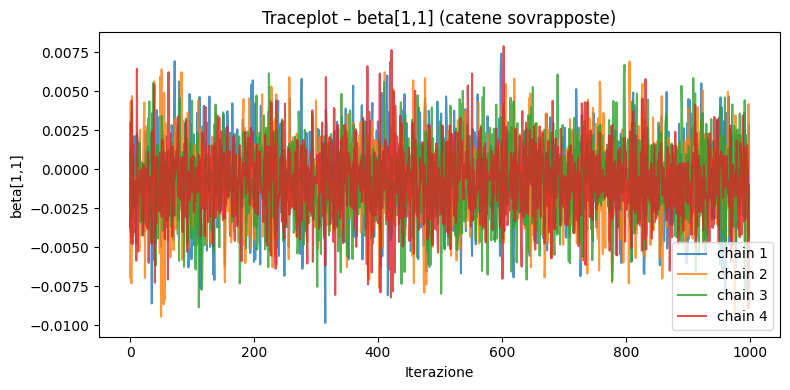

In [38]:
# Interesting plots

beta = fit.stan_variable("beta")
tot_draws, P, K = beta.shape
chains = fit.chains # number of chains
iters = tot_draws // chains # number of draws per chain

beta_chains = beta.reshape(chains, iters, P, K)

fig, ax = plt.subplots(figsize=(8, 4))

for c in range(chains):
    ax.plot(beta_chains[c, :, 0, 0], label=f"chain {c+1}", alpha=0.8)

ax.set_xlabel("Iterazione")
ax.set_ylabel(f"beta[{0+1},{0+1}]")
ax.set_title(f"Traceplot – beta[{0+1},{0+1}] (catene sovrapposte)")
ax.legend()
plt.tight_layout()
plt.show()

In [41]:
with open("Model_4_SESSO.pkl", "wb") as f:
    pickle.dump(fit, f)

In [42]:
import pickle
with open("Model_4_SESSO.pkl", "rb") as f:
    fit = pickle.load(f)

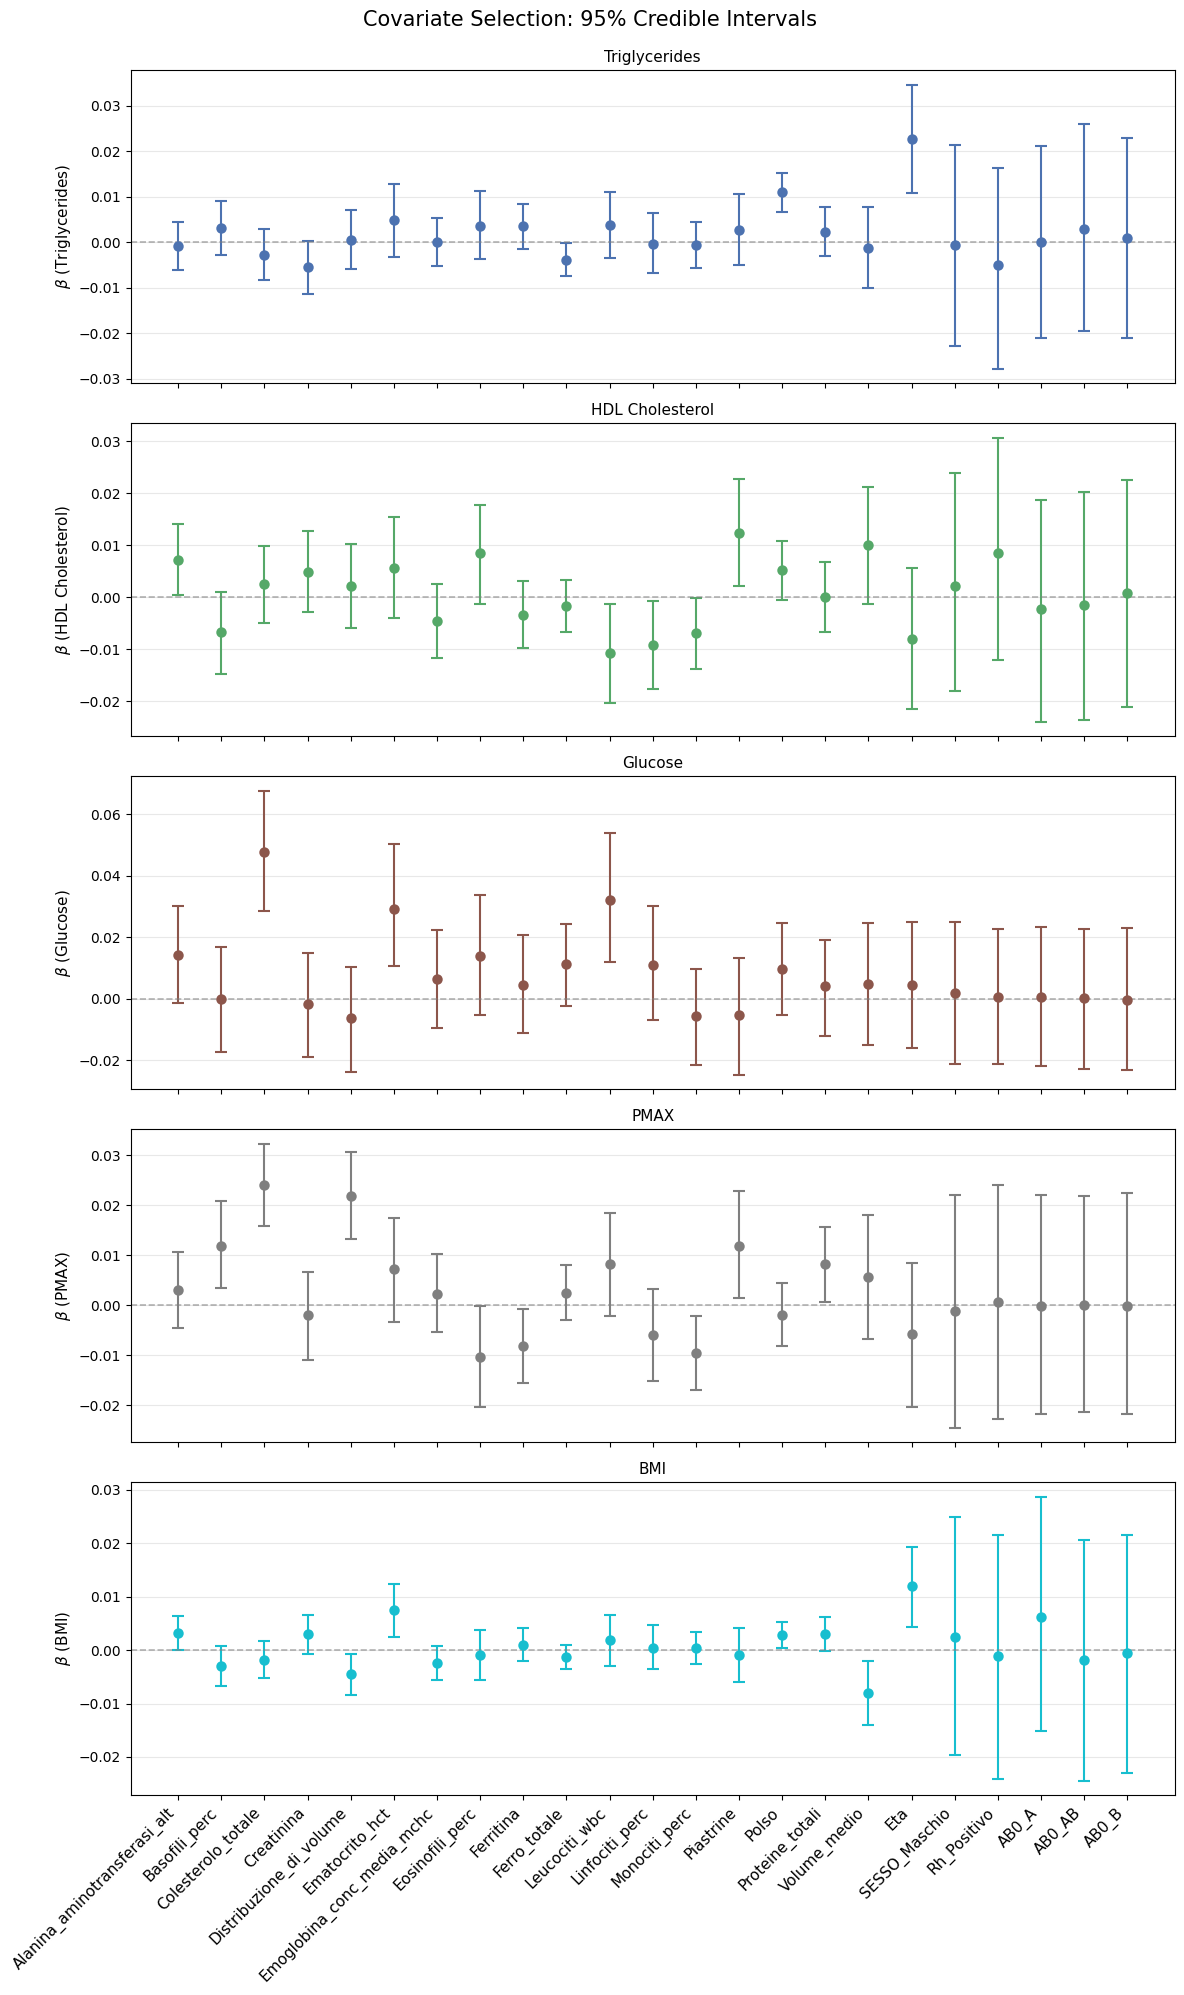

In [43]:
import matplotlib.pyplot as plt
ID_COL = "CAI"
TARGET_COLS = ["Trigliceridi", "Colesterolo_Hdl", "Glucosio", "PMAX", "BMI"]
numeric_cols = df.select_dtypes(exclude=["object", "category"]).columns.tolist()
COVARIATE_COLS = [c for c in numeric_cols if c not in TARGET_COLS + [ID_COL]]

data = fit.stan_variables()
beta_samples = data['beta']

if beta_samples.ndim == 3 and beta_samples.shape[-1] == 5:
    beta_samples = np.swapaxes(beta_samples, 1, 2)

n_targets = beta_samples.shape[1]
n_features = beta_samples.shape[2]

means = np.mean(beta_samples, axis=0)              # Shape: (n_targets, n_features)
lower = np.percentile(beta_samples, 2.5, axis=0)   # Shape: (n_targets, n_features)
upper = np.percentile(beta_samples, 97.5, axis=0)  # Shape: (n_targets, n_features)

y_pos = np.arange(n_features)
target_names = ['Triglycerides', 'HDL Cholesterol', 'Glucose', 'PMAX', 'BMI']
colors = ['#4c72b0', '#55a868', '#8c564b', '#7f7f7f', '#17becf']

fig, axes = plt.subplots(nrows=n_targets, ncols=1,
                         figsize=(12, 4 * n_targets),
                         sharex=True)

if n_targets == 1: axes = [axes]

for i, ax in enumerate(axes):
    y_mean = means[i, :]
    y_low = lower[i, :]
    y_high = upper[i, :]
    y_err = [y_mean - y_low, y_high - y_mean]
    col = colors[i % len(colors)]
    ax.errorbar(x=y_pos, y=y_mean, yerr=y_err, fmt='o',
                markersize=6, capsize=4,
                color=col, ecolor=col,
                elinewidth=1.5, markeredgewidth=1.5)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.2, alpha=0.6)
    if i < len(target_names):
        t_name = target_names[i]
    else:
        t_name = f"Target {i+1}"

    ax.set_title(t_name, fontsize=11)
    ax.set_ylabel(fr'$\beta$ ({t_name})', fontsize=11)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)

axes[-1].set_xticks(y_pos)
axes[-1].set_xticklabels(COVARIATE_COLS, rotation=45, ha='right', fontsize=11)

fig.suptitle('Covariate Selection: 95% Credible Intervals', fontsize=15, y=0.995)

plt.tight_layout()
plt.show()